In [6]:
%pip install osm2geojson==0.2.4 pystac_client==0.6.1 stackstac==0.4.4

  Preparing metadata (setup.py) ... done
  Obtaining dependency information for stackstac==0.4.4 from https://files.pythonhosted.org/packages/81/22/3bb47276aa898638fcaf24bd73db6acc8249cfaccb6b1021e579045c1868/stackstac-0.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for pystac>=1.7.0 from https://files.pythonhosted.org/packages/d9/33/528355f091d6522e5f11e02b1309cb4713e21ef8f772dd9b38e8276da011/pystac-1.8.4-py3-none-any.whl.metadata
  Obtaining dependency information for dask[array]>=2022.1.1 from https://files.pythonhosted.org/packages/f5/ec/3613b5221a015f54ff50a948029bbd7564e846a45178070feced8b9d105c/dask-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2021.09.0 from https://files.pythonhosted.org/packages/fe/d3/e1aa96437d944fbb9cc95d0316e25583886e9cd9e6adc07baad943524eda/fsspec-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for partd>=1.2.0 from https://files.pythonhosted.org/packages/11/8a/b7a58e208b144a7315

In [1]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import ClassificationImageDataset
from rastervision.pytorch_learner import ClassificationImageDataConfig
from rastervision.pytorch_learner import SolverConfig, ClassificationModelConfig
from rastervision.pytorch_learner import ClassificationLearnerConfig
from rastervision.pytorch_learner import ClassificationLearner

import albumentations as A

In [2]:
class_config = ClassConfig(
    names=[
        'AnnualCrop',
        'HerbaceousVegetation',
        'Industrial',
        'PermanentCrop',
        'River',
        'Forest',
        'Highway',
        'Pasture',
        'Residential',
        'SeaLake',
])

In [3]:
base_tf = A.Resize(256, 256)

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        # A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=8, max_width=8, max_holes=5),
    base_tf,
])

train_ds = ClassificationImageDataset(
    data_dir='EuroSAT_RGB/train',
    class_names=class_config.names,
    transform=data_augmentation_transform,
)

val_ds = ClassificationImageDataset(
    data_dir='EuroSAT_RGB/val',
    class_names=class_config.names,
    transform=base_tf,
)
len(train_ds), len(val_ds)

(22000, 5000)

In [5]:
data_cfg = ClassificationImageDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    img_channels=3,
    num_workers=4,
)

solver_cfg = SolverConfig(
    batch_sz=16,
    lr=3e-4,
)

model_cfg = ClassificationModelConfig(backbone='resnet18', pretrained=True)


learner_cfg = ClassificationLearnerConfig(
    data=data_cfg, 
    model=model_cfg,
    solver=solver_cfg,
    save_all_checkpoints=True,
)

In [8]:

learner = ClassificationLearner(
    cfg=learner_cfg,
    output_dir='./eurosat/train/',
    train_ds=train_ds,
    valid_ds=val_ds,
)

2023-09-27 21:15:39:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./eurosat/train/last-model.pth


In [20]:
learner.log_data_stats()

2023-09-27 21:07:42:rastervision.pytorch_learner.learner: INFO - train_ds: 22000 items
2023-09-27 21:07:42:rastervision.pytorch_learner.learner: INFO - valid_ds: 5000 items


In [22]:
learner.plot_dataloaders()

2023-09-27 21:08:41:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2023-09-27 21:08:41:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.


In [9]:
learner.train(epochs=2)

2023-09-27 21:15:56:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2023-09-27 21:15:56:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Validating:   0%|          | 0/313 [00:00<?, ?it/s]

2023-09-27 21:16:37:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 3,
 'train_loss': 0.2789992392063141,
 'train_time': '0:00:37.818065',
 'val_loss': 0.1016407459974289,
 'avg_precision': 0.9686640501022339,
 'avg_recall': 0.9684000015258789,
 'avg_f1': 0.9685320258140564,
 'AnnualCrop_precision': 0.9611452221870422,
 'AnnualCrop_recall': 0.9399999976158142,
 'AnnualCrop_f1': 0.9504550695419312,
 'HerbaceousVegetation_precision': 0.9536290168762207,
 'HerbaceousVegetation_recall': 0.9459999799728394,
 'HerbaceousVegetation_f1': 0.9497991800308228,
 'Industrial_precision': 0.97265625,
 'Industrial_recall': 0.9959999918937683,
 'Industrial_f1': 0.9841896891593933,
 'PermanentCrop_precision': 0.9115384817123413,
 'PermanentCrop_recall': 0.9480000138282776,
 'PermanentCrop_f1': 0.929411768913269,
 'River_precision': 0.9738956093788147,
 'River_recall': 0.9700000286102295,
 'River_f1': 0.9719439744949341,
 'Forest_precision': 0.9744094610214233,
 'Forest_recall': 0.9900000

Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Validating:   0%|          | 0/313 [00:00<?, ?it/s]

2023-09-27 21:17:37:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 4,
 'train_loss': 0.26053762435913086,
 'train_time': '0:00:57.086380',
 'val_loss': 0.1302700787782669,
 'avg_precision': 0.9620564579963684,
 'avg_recall': 0.9595999717712402,
 'avg_f1': 0.9608266949653625,
 'AnnualCrop_precision': 0.9239543676376343,
 'AnnualCrop_recall': 0.972000002861023,
 'AnnualCrop_f1': 0.9473683834075928,
 'HerbaceousVegetation_precision': 0.9487179517745972,
 'HerbaceousVegetation_recall': 0.8880000114440918,
 'HerbaceousVegetation_f1': 0.9173553586006165,
 'Industrial_precision': 0.9938398599624634,
 'Industrial_recall': 0.9679999947547913,
 'Industrial_f1': 0.9807497262954712,
 'PermanentCrop_precision': 0.8382608890533447,
 'PermanentCrop_recall': 0.9639999866485596,
 'PermanentCrop_f1': 0.8967441916465759,
 'River_precision': 0.9855072498321533,
 'River_recall': 0.9520000219345093,
 'River_f1': 0.9684638977050781,
 'Forest_precision': 0.9920159578323364,
 'Forest_recall': 

2023-09-27 21:18:09:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


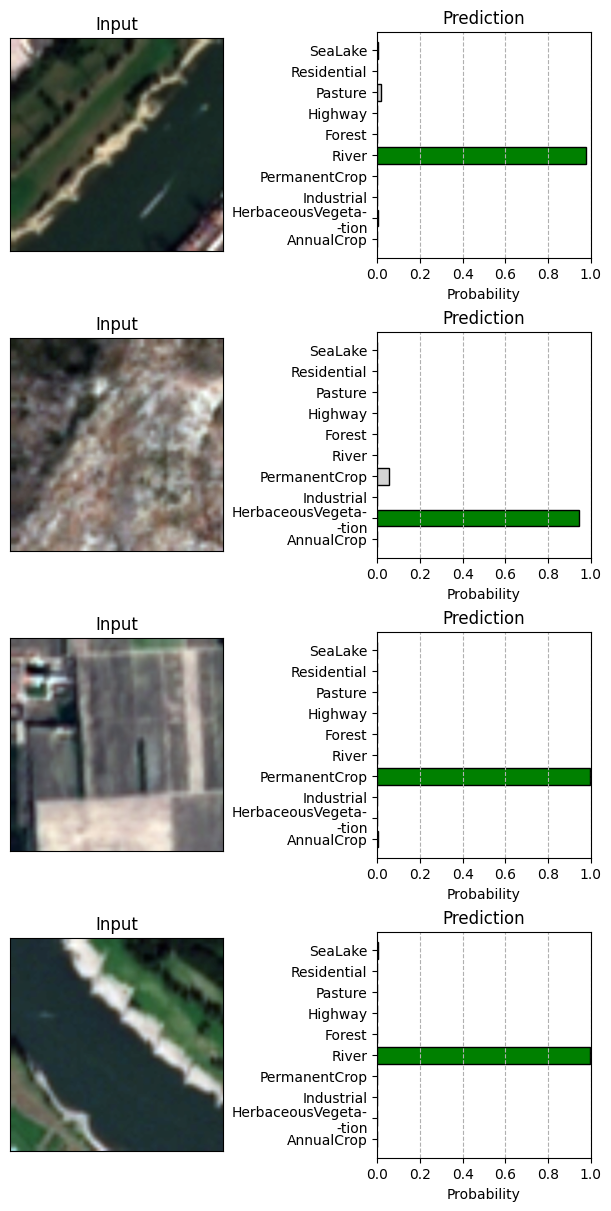

2023-09-27 21:18:10:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./eurosat/train/valid_preds.png.


In [11]:
learner.plot_predictions(split='valid', batch_limit=4, show=True)

In [65]:
learner.save_model_bundle(export_onnx=False)

2023-09-27 23:05:35:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2023-09-27 23:05:35:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./eurosat/train/model-bundle.zip.


---

# Prediction

In [3]:
learner = ClassificationLearner.from_model_bundle(
    'eurosat/train/model-bundle.zip', 
    output_dir='./eurosat/train/',
    training=False,
)

2023-09-28 13:19:37:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle eurosat/train/model-bundle.zip.
2023-09-28 13:19:37:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpvncwffsb/model-bundle
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 28.1MB/s]
2023-09-28 13:19:40:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpvncwffsb/model-bundle/model.pth


## Get Sentinel-2 imagery from STAC API as a `DataArray`

In [9]:
%pip install stac-asset

  Obtaining dependency information for stac-asset from https://files.pythonhosted.org/packages/ef/f6/09cb04784349f1d8c914c0279fa04dd4b56ebede17e48d80fb0387dea5cc/stac_asset-0.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles>=23.1.0 from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for aiobotocore>=2.5.0 from https://files.pythonhosted.org/packages/30/f5/495f81a2bb24f5b876cadb84be802d4dbf0c5707aa8e9102614444b4cd05/aiobotocore-2.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiohttp>=3.8.4 from https://files.pythonhosted.org/packages/3e/f6/fcda07dd1e72260989f0b22dde999ecfe80daa744f23ca167083683399bc/aiohttp-3.8.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.6 MB/s eta 0:00:0000:0100:01
  Obtaining dependency informati

In [7]:
from rastervision.core.box import Box
from rastervision.core.data import (
    ChipClassificationLabels, RasterioCRSTransformer, Scene, StatsTransformer, 
    XarraySource)
from rastervision.core.data.utils import (get_polygons_from_uris)
from rastervision.pytorch_learner.dataset import (
    ClassificationSlidingWindowGeoDataset)

from shapely.geometry import mapping
import pystac_client
import stackstac

In [8]:
bbox = Box(ymin=23.5170057, xmin=58.2066668, ymax=23.6448968, xmax=58.6326003)
bbox_geometry = mapping(bbox.to_shapely())
bbox, bbox_geometry

(Box(ymin=23.5170057, xmin=58.2066668, ymax=23.6448968, xmax=58.6326003),
 {'type': 'Polygon',
  'coordinates': (((58.2066668, 23.5170057),
    (58.2066668, 23.6448968),
    (58.6326003, 23.6448968),
    (58.6326003, 23.5170057),
    (58.2066668, 23.5170057)),)})

In [10]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2023-09-12/2023-09-12",
    query={"eo:cloud_cover": {"lt": 5}},
).get_all_items()

stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-f6b9f69f677405aea06e1f20027dc60c' (time: 1,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(1, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-09-12...
    id                                       (time) <U24 'S2B_40QFM_20230912_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 2.7e+06 ... 2.59e+06
    s2:vegetation_percentage                 float64 0.07266
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32640
Attributes:
    spec:        RasterSpec(epsg=32640, bounds=(600000.0, 2590200.0, 709800.0...
    crs:         epsg:32640
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 2700000.00|\n| 0.0...
    resolution:  10.0

In [27]:
item = items[0]

In [33]:
rgb_assets = {k: v.href for k, v in item.get_assets().items() if k in ['red', 'green', 'blue']}
rgb_assets

{'blue': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B02.tif',
 'green': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B03.tif',
 'red': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B04.tif'}

In [ ]:
!wget -P "oman-imagery/" "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B04.tif"
!wget -P "oman-imagery/" "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B03.tif"
!wget -P "oman-imagery/" "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/40/Q/FM/2023/9/S2B_40QFM_20230912_0_L2A/B02.tif"

In [42]:
!gdalbuildvrt -separate "oman-imagery/RGB_20230912.vrt" \
    "oman-imagery/B04.tif" \
    "oman-imagery/B03.tif" \
    "oman-imagery/B02.tif"
!gdal_translate "oman-imagery/RGB_20230912.vrt" "oman-imagery/RGB_20230912.tif"

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.


Task exception was never retrieved
future: <Task finished name='Task-8' coro=<download_item() done, defined at /tmp/ipykernel_90/3498553618.py:4> exception=RuntimeError('asyncio.run() cannot be called from a running event loop')>
Traceback (most recent call last):
  File "/tmp/ipykernel_90/3498553618.py", line 5, in download_item
    return stac_asset.blocking.download_item(item, "oman-imagery/")
  File "/opt/conda/lib/python3.10/site-packages/stac_asset/blocking.py", line 47, in download_item
    return asyncio.run(
  File "/opt/conda/lib/python3.10/asyncio/runners.py", line 33, in run
    raise RuntimeError(
RuntimeError: asyncio.run() cannot be called from a running event loop


### Convert to a Raster Vision `RasterSource`

In [24]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [25]:
data_array = stack
data_array = data_array.isel(time=-1)
data_array = data_array.sel(
    band=[
        'red', # B04
        'green', # B03
        'blue', # B02
    ])

In [9]:
bbox_pixel_coords = crs_transformer.map_to_pixel(bbox).normalize()

raster_source_unnormalized = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    bbox=bbox_pixel_coords,
)
stats_tf = StatsTransformer.from_raster_sources([raster_source_unnormalized])

raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    bbox=bbox_pixel_coords,
)
raster_source.shape

Analyzing chips: 0it [00:00, ?it/s]

(1459, 4333, 3)

Visualize the full image (within the city's bounding box):

In [10]:
_ = data_array.load()

In [11]:
aoi_polygons = get_polygons_from_uris('aoi_Muscat.json', crs_transformer)
scene = Scene(
    id='test_scene',
    raster_source=raster_source,
    aoi_polygons=aoi_polygons,
)

In [12]:
pred_ds = ClassificationSlidingWindowGeoDataset(
    scene=scene, 
    size=64, 
    stride=64, 
    transform=A.Resize(256, 256),
)
len(pred_ds)

1564

In [13]:
predictions = learner.predict_dataset(
    pred_ds,
    raw_out=True,
    numpy_out=True,
    progress_bar=True,
    dataloader_kw=dict(num_workers=0),
)
labels = ChipClassificationLabels.from_predictions(pred_ds.windows, predictions)

Predicting:   0%|          | 0/1564 [00:00<?, ?it/s]

In [28]:
labels.save(
    'eurosat/predict/muscat.json', 
    class_config, 
    crs_transformer, 
    bbox=raster_source.bbox)

In [31]:
arr = raster_source[:, :]
arr.shape

(1459, 4333, 3)

In [30]:
from rastervision.core.data.utils import write_bbox
import pyproj

In [59]:
bbox, crs_transformer.pixel_to_map(raster_source.bbox)

(Box(ymin=23.5170057, xmin=58.2066668, ymax=23.6448968, xmax=58.6326003),
 Box(ymin=23.648794076348786, xmin=58.20790834069194, ymax=23.513168486467464, xmax=58.631007085025566))

In [33]:
write_bbox(
    'muscat_rgb.tif', 
    arr, 
    bbox=crs_transformer.pixel_to_map(raster_source.bbox).normalize(), 
    crs_wkt=pyproj.CRS('epsg:4326').to_wkt(),
)